In [655]:
from utils import *

In [656]:
json_path = r'data/catchments_long.json'
catchment_dict_list = long_json_to_list(json_path)

In [657]:
demo_catchment = catchment_dict_list[0]

grid_by_num_splits = corners_to_grid_by_num_splits(demo_catchment, 100)

In [658]:
api_response = elevation_api_caller(grid_by_num_splits)

In [659]:
elevation_grid_by_num_splits = parse_api_resonse_to_dataframe(api_response)

In [660]:
pivoted_elevation_grid_by_num_splits = elevation_grid_by_num_splits.pivot(index='latitude', columns='longitude', values='elevation')

In [661]:
transposed_pivoted_elevation_grid_by_num_splits = pivoted_elevation_grid_by_num_splits.transpose()

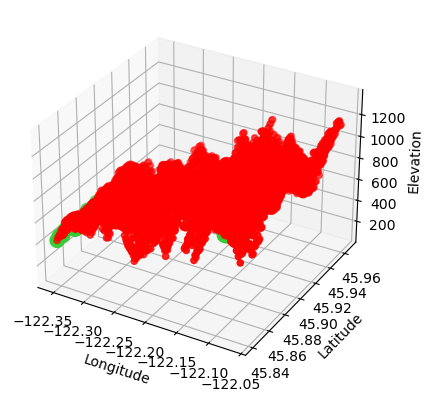

In [662]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.ndimage as ndi

elevation_data = elevation_grid_by_num_splits
elevation_values = elevation_data['elevation']  # Assuming elevation values are stored in this column

# Create a local minima mask
local_minima_mask = elevation_values == ndi.minimum_filter(elevation_values, size=200)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with elevation as height
ax.scatter(elevation_data['longitude'], elevation_data['latitude'], elevation_data['elevation'], c='r', marker='o')

minima_x = elevation_data['longitude'][local_minima_mask]
minima_y = elevation_data['latitude'][local_minima_mask]
minima_z = elevation_data['elevation'][local_minima_mask]


ax.scatter(minima_x, minima_y, minima_z, c='limegreen', marker='o', s=100)  # Adjust 's' to control marker size

# Set labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Elevation')

# Show the plot
plt.show()

In [663]:
import plotly.express as px

fig = px.scatter_3d(elevation_grid_by_num_splits, x='longitude', y='latitude', z='elevation', title='Elevation 3D Scatter Plot')

# Show the plot
fig.show()

In [664]:
#this one works!
import plotly.graph_objects as go
import numpy as np
z = np.array(elevation_grid_by_num_splits['elevation'])
x = np.array(elevation_grid_by_num_splits['latitude'])
y = np.array(elevation_grid_by_num_splits['longitude'])


#fig = go.Figure(data=[go.Surface(z=elevation_grid_by_num_splits.values[2], x=elevation_grid_by_num_splits.values[0], y=elevation_grid_by_num_splits.values[1])])

fig = go.Figure(data=[go.Surface(z=pivoted_elevation_grid_by_num_splits.values, x=pivoted_elevation_grid_by_num_splits.index, y=pivoted_elevation_grid_by_num_splits.columns)])


fig.update_layout(
    scene=dict(
        aspectratio=dict(x=1, y=1, z=0.2),
        aspectmode='manual'
    )
)

fig.show()

In [665]:
#for plotting local minima
import plotly.graph_objects as go
import numpy as np
import scipy.ndimage as ndi

z = np.array(elevation_grid_by_num_splits['elevation'])
x = np.array(elevation_grid_by_num_splits['latitude'])
y = np.array(elevation_grid_by_num_splits['longitude'])

# Create a local minima mask
local_minima_mask = elevation_values == ndi.minimum_filter(z, size=50)

# Extracting the minima coordinates
minima_x = x[local_minima_mask]
minima_y = y[local_minima_mask]
minima_z = z[local_minima_mask]

# Plot our elevation data, 
fig = go.Figure(data=[go.Surface(z=pivoted_elevation_grid_by_num_splits.transpose().values, x=pivoted_elevation_grid_by_num_splits.index, y=pivoted_elevation_grid_by_num_splits.columns)])
# fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5, color='limegreen', symbol='circle'), name='Scatterplot surface'))  # plots all points in scatterplot form

# Plot the local minima alongside the elevation data (as determined by the ndi filter)
fig.add_trace(go.Scatter3d(x=minima_x, y=minima_y, z=minima_z, mode='markers', marker=dict(size=5, color='limegreen', symbol='circle'), name='Local Minima'))

fig.update_layout(
    scene=dict(
        aspectratio=dict(x=1, y=1, z=0.2),
        aspectmode='manual'
    )
)

fig.show()

In [666]:
# test_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')